<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-relevant-data" data-toc-modified-id="Load-relevant-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load relevant data</a></span></li><li><span><a href="#Standard-Scale-the-Climatic-data" data-toc-modified-id="Standard-Scale-the-Climatic-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Standard Scale the Climatic data</a></span></li><li><span><a href="#Regression-task" data-toc-modified-id="Regression-task-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regression task</a></span></li></ul></div>

In [38]:
import ee
import datetime
import pandas as pd
from IPython.display import Image
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
import json
from shapely.geometry import Polygon, MultiPolygon, Point
import geojson
import pickle
import warnings
warnings.filterwarnings('ignore')
import iisignature
import sys
sys.path.append("../")
from utils.addtime import AddTime, LeadLag
from importlib import reload
import utils.experiments as experiments 
import GP_models.GP_sig_precomputed as GP_sig
from IPython.display import Image
import utils.signature_features as signature_features
import esig.tosig as esig
import os
from sklearn.preprocessing import StandardScaler

# Load relevant data

In [18]:
base_dir = '/Users/maudlemercier/Desktop/Distribution_Regression_Streams/data_France/'

The NUTS2 regions have been renamed in 2013, hence we need to take this into account when reading the data for years before and after 2013

In [19]:
dico_nuts_2016 = {'FRE1':'FR30','FRE2':'FR22','FR10':'FR10','FRF2':'FR21','FRF3':'FR41','FRF1':'FR42','FRC2':'FR43','FRK2':'FR71','FRL0':'FR82','FRJ1':'FR81','FRJ2':'FR62','FRI1':'FR61','FRI3':'FR53','FRI2':'FR63','FRK1':'FR72','FRH0':'FR52','FRG0':'FR51','FRB0':'FR24','FRD1':'FR25','FRD2':'FR23','FRC1':'FR26','FRM0':'FR83'}
dico_nuts_2013 = {}
for key in dico_nuts_2016.keys():
    dico_nuts_2013[dico_nuts_2016[key]]=key

Load the yield data which have been preprocessed

In [20]:
dy = pickle.load(open(base_dir+'yield_data_processed_France.obj','rb'))

Load the yield dataframe merged with the polygons `data` 

In [21]:
data = pickle.load(open(base_dir+'yield_dataframe_processed_France.obj','rb'))

# Standard Scale the Climatic data

Reorganize the data into folders

In [39]:
# def mkdir_p(path):
#     try:
#         os.makedirs(path)
#     except OSError as exc:  # Python >2.5
#         if exc.errno == errno.EEXIST and os.path.isdir(path):
#             pass
#         else:
#             raise

# clim_var = ['AvgSurfT_inst_', 'SoilMoi0_10cm_inst_', 'Rainf_f_tavg_']
            
# # create one directory per nut
# for nut in dico_nuts_2016.keys():
#     mkdir_p(os.path.join(base_dir+'disaggregated_dataframes', nut))

# # Create a list of time series on which we will fit the standard scaler
# training_list = []
# for year in years[:-1]:
#     print('year: ', year)
#     for nut in dico_nuts_2016.keys():
#         clim = pickle.load(open(base_dir+nut+'_2005_2018.obj','rb'))
        
#         # subset the dataframe on the correct year
#         clim = clim.loc[str(year)+'-01-01':str(year)+'-11-01']
        
#         # number of pixels in nut
#         nb_pixels = int(len(clim.columns)/3)
#         for pix in range(nb_pixels):
#             col_pix = [clim_var[i]+str(pix) for i in range(3)]
#             training_list.append(clim[col_pix].to_numpy())
            
# ## Fit the standard scaler on the training data
# scaler = StandardScaler()

# to_fit = np.concatenate(training_list, axis=0)

# # fit the scaler
# scaler.fit(to_fit)

StandardScaler(copy=True, with_mean=True, with_std=True)

We have fitted the standard scaler. Now we transform the dataset, and save the results

In [ ]:
# for year in years:
#     print(year)
#     for nut in dico_nuts_2016.keys():
        
#         # will be a list of numpy arrays corresponding to the pixels within the nut for that year
#         pixels = []
        
#         # subset the dataframe on the correct year
#         clim = pickle.load(open(base_dir+nut+'_2005_2018.obj','rb'))
#         clim = clim.loc[str(year)+'-01-01':str(year)+'-11-01']

#         # number of pixels in nut
#         nb_pixels = int(len(clim.columns)/3)
#         for pix in range(nb_pixels):
#             col_pix = [clim_var[i]+str(pix) for i in range(3)]
#             pixels.append(scaler.transform(clim[col_pix].to_numpy()))
#         pickle.dump(pixels,open(base_dir+'disaggregated_dataframes/'+nut+'/'+str(year)+'.obj','wb'))

# Regression task

In [127]:
# signature spec
level_sig = 2
add_time_tf = AddTime()
lead_lag_tf = LeadLag([1])
sig_level1 = 4
sig_level2 = 2

# to store the input/output pairs
expected_sigs = [] 
labels = {}
input_list = []

for year in years:
    
    print('year: ', year)
    
    for nut in dico_nuts_2016.keys():

        # load the standardized pixel data
        pixels = pickle.load(open(base_dir+'disaggregated_dataframes/'+str(nut)+'/'+year+'.obj','rb'))
        pixels = add_time_tf.fit_transform([e[:-500,0] for e in pixels]) 
        pixels = lead_lag_tf.fit_transform(pixels)
        expected_sig = np.mean(iisignature.sig(pixels,level_sig),axis=0)
        expected_sigs.append(expected_sig)

        label = data[data.year==year]
        label = label[label.NUTS_ID==nut].PR_div_AR.values[0]
        labels[(year,nut)]=label

# # save the paths for comparison with baseline    
# pickle.dump(input_list,open('input_list_RBF.obj','wb')) 
# pickle.dump(np.array([labels[key] for key in labels.keys()])[:,None],open('output_RBF.obj','wb')) 

year:  2006
year:  2007
year:  2008
year:  2009
year:  2010
year:  2011
year:  2012
year:  2013
year:  2015
year:  2016
year:  2017


 Precompute the Gram Matrix with elements $\langle \mathbb{E}[S(x^i)],\mathbb{E}[S(x^j)]\rangle$

In [128]:

train_indices = np.arange(220)
test_indices = np.arange(220,242)

features = np.array(expected_sigs) 
print(features.shape)

# Scale the (expected) signature features
scaler = StandardScaler()
to_fit = [features[i] for i in train_indices]
scaler.fit(to_fit)
features = scaler.transform(features)

# feat_select = [3,9,10,30]
# features = features[:,feat_select]
# print(features.shape)

# # Precompute the Gram matrix
K_precomputed = experiments.precompute_K(features)

(242, 12)


Fit the model

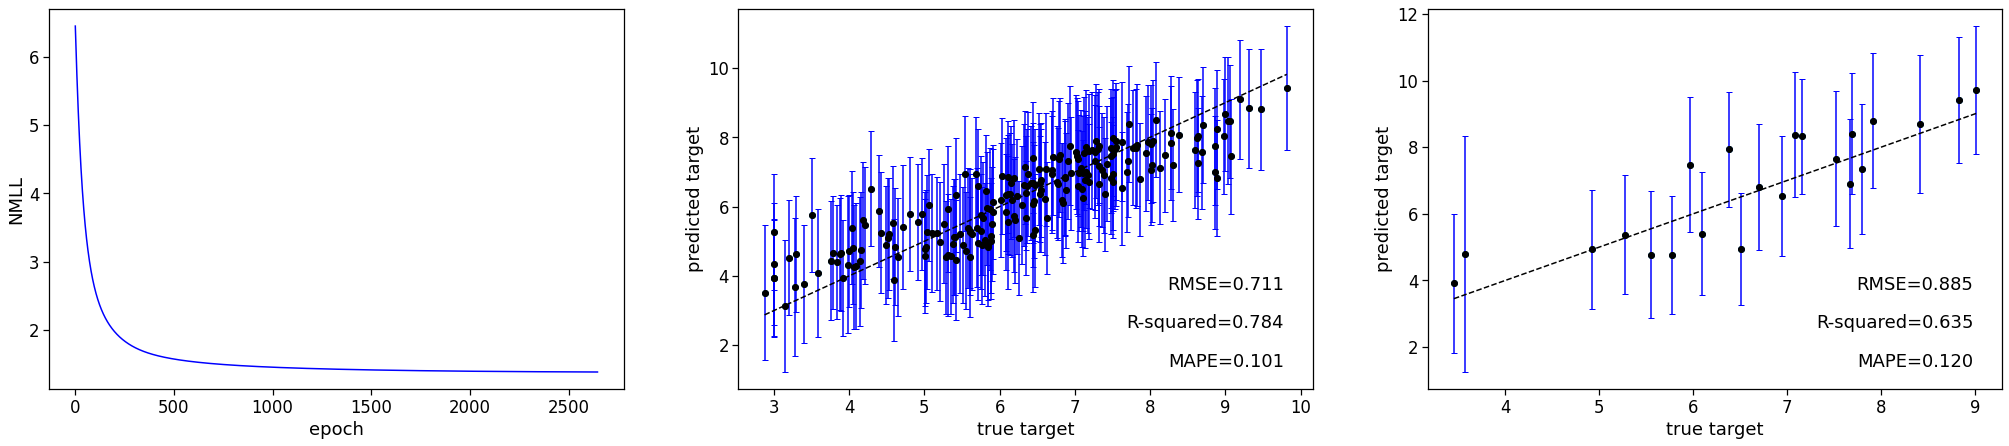

In [135]:
reload(experiments)
reload(GP_sig)
import GP_models.GP_sig_ARD_full as GP_sig_ARD_full
reload(GP_sig_ARD_full)
a,b,c,d = experiments.experiment_precomputed(K_precomputed, np.array([labels[key] for key in labels.keys()])[:,None],train_indices,test_indices,param_init=[0,0,0],RBF=True,plot=True)
#a,b,c,d,l = experiments.experiment_ARD(features,np.array([labels[key] for key in labels.keys()])[:,None],5,level_sig,train_indices,test_indices,param_init=[0,0,0],RBF=True,plot=True,full=True)

12
12


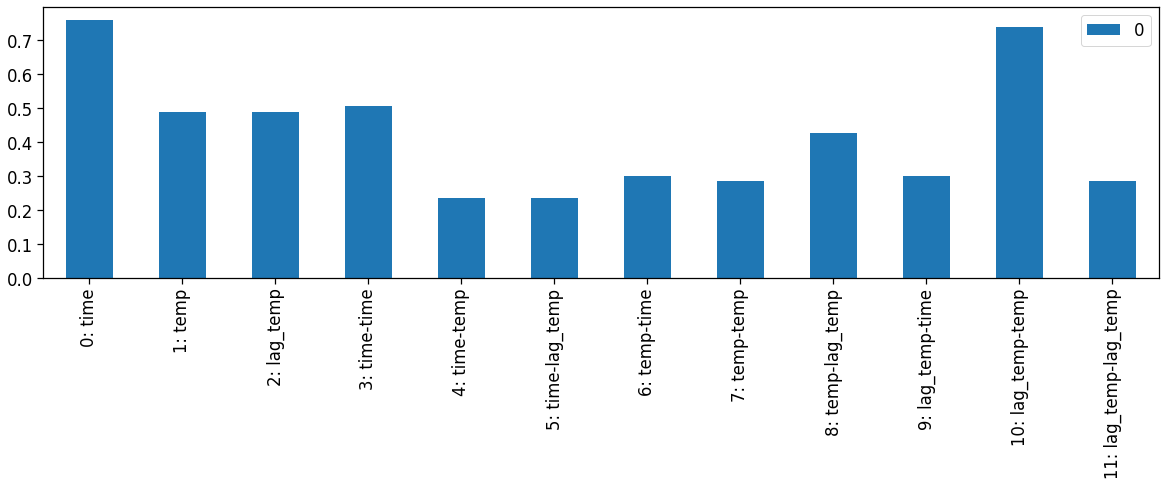

In [134]:
def get_sig_keys(ndims, sig_level):
    keys = esig.sigkeys(ndims,sig_level).split("(")
    sig_keys = []

    for i in range(2,len(keys)-1):
        sig_keys.append(np.array(keys[i][:-2].split(',')))
    sig_keys.append(np.array(keys[len(keys)-1][:-1].split(',')))
    return sig_keys
keys = get_sig_keys(3, level_sig)
#dico = {'1':'time', '2':'nir','3':'red','4':'nir_l','5':'red_l'}#,'3':'red','4':'nir-lag'}
dico = {'1':'time','2':'temp','3':'lag_temp'}#,'4':'red_l'}
features_names = []
for i in range(features.shape[1]):
    separator = '-'
    name = separator.join([dico[e] for e in keys[i]])
    features_names.append(str(i)+': '+name)
print(len(features_names))
print(features.shape[1])
fig, ax = plt.subplots(1,figsize=(20,5))
lengthscales = pd.DataFrame([1./e for e in l])
lengthscales.index = features_names
lengthscales.plot(kind='bar',ax=ax,rot=90)
plt.show()

